# Libraries

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from tabulate import tabulate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

# Set the File Path for the Data


In [4]:
file_paths = [
  "foia-7afy1991-fy1999-asof-221231.csv",
  "foia-7afy2000-fy2009-asof-221231.csv",
  "foia-7afy2010-fy2019-asof-221231.csv"
]

#load dataset and combine into one df
dfs = [pd.read_csv(file, encoding='latin-1', low_memory=False) for file in file_paths]
combined_df = pd.concat(dfs, ignore_index=True)
combined_df2 = combined_df.copy()

#show count of rows and columns of df
print("Dataset shape:", combined_df.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset shape: (986334, 39)


# Missing Values and Statistics for the Data

In [5]:
#summary statistics
print("\nSummary Statistics:")
print(combined_df.describe(include='all'))

#missing values
print("\nMissing Values:")
print(combined_df.isnull().sum())

#data types and missing values
print(combined_df.info())
#statistics for numerical fields
print(combined_df.describe())
#statistics for categorical fields
categorical_columns = combined_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\nSummary for {col}:")
    print(combined_df[col].value_counts())
#null values in each column
null_counts = combined_df.isnull().sum()
print(null_counts[null_counts > 0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Summary Statistics:
          AsOfDate Program BorrName   BorrStreet BorrCity BorrState  \
count     986334.0  986334   986291       986209   986309    986306   
unique         NaN       1   816097       871773    36939        60   
top            NaN      7A   SUBWAY  MAIN STREET  HOUSTON        CA   
freq           NaN  986334      596          367     9756    128938   
mean    20221231.0     NaN      NaN          NaN      NaN       NaN   
std            0.0     NaN      NaN          NaN      NaN       NaN   
min     20221231.0     NaN      NaN          NaN      NaN       NaN   
25%     20221231.0     NaN      NaN          NaN      NaN       NaN   
50%     20221231.0     NaN      NaN          NaN      NaN       NaN   
75%     20221231.0     NaN      NaN          NaN      NaN       NaN   
max     20221231.0     NaN      NaN          NaN      NaN       NaN   

              BorrZip                                BankName  BankFDICNumber  \
count   986334.000000                        

# Data Cleaning with Reducing

In [6]:
### Data Cleaning
#drop columns with more than 40% missing values (too many missing values)
threshold = len(combined_df) * 0.4
combined_df = combined_df.dropna(thresh=threshold, axis=1)

#missing values for numerical columns
numerical_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_imputer = SimpleImputer(strategy='median')
combined_df[numerical_cols] = numerical_imputer.fit_transform(combined_df[numerical_cols])

#missing values for categorical columns
categorical_cols = combined_df.select_dtypes(include=['object']).columns.tolist()
categorical_imputer = SimpleImputer(strategy='most_frequent')
combined_df[categorical_cols] = categorical_imputer.fit_transform(combined_df[categorical_cols])

#convert 'LoanStatus' to binary
combined_df['LoanStatus'] = combined_df['LoanStatus'].map({'PIF': 1, 'CHGOFF': 0})

#all numerical columns are numeric
for col in numerical_cols:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

#drop rows with any remaining missing values
combined_df.dropna(inplace=True)

#Review Final Combined_df for Accuracy
print(combined_df.info())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
Index: 727511 entries, 0 to 986329
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AsOfDate               727511 non-null  float64
 1   Program                727511 non-null  object 
 2   BorrName               727511 non-null  object 
 3   BorrStreet             727511 non-null  object 
 4   BorrCity               727511 non-null  object 
 5   BorrState              727511 non-null  object 
 6   BorrZip                727511 non-null  float64
 7   BankName               727511 non-null  object 
 8   BankFDICNumber         727511 non-null  float64
 9   BankStreet             727511 non-null  object 
 10  BankCity               727511 non-null  object 
 11  BankState              727511 non-null  object 
 12  BankZip                727511 non-null  object 
 13  GrossApproval          727511 non-null  float64
 14  SBAGuaranteedApproval  727511 non-null  f

# Chi Squared Testing

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Chi-Square Test for BorrState and GrossChargeOffCategory:
Chi2: 1450.6345860777324
p-value: 5.9186028988961144e-142
Degrees of Freedom: 324
Expected Frequencies: 
[[1.48014170e+01 1.21608345e+02 1.22613003e+01 5.05989635e+00
  1.09414157e+00 1.46427869e-01 2.84720855e-02]
 [9.05273765e+01 7.43772328e+02 7.49916945e+01 3.09469789e+01
  6.69191104e+00 8.95571738e-01 1.74138949e-01]
 [8.78535721e+01 7.21804369e+02 7.27767500e+01 3.00329331e+01
  6.49425966e+00 8.69120252e-01 1.68995605e-01]
 [1.20416690e+02 9.89342728e+02 9.97516106e+01 4.11647051e+01
  8.90137112e+00 1.19126156e+00 2.31634193e-01]
 [8.26396536e+02 6.78966849e+03 6.84576081e+02 2.82505439e+02
  6.10883947e+01 8.17539854e+00 1.58966083e+00]
 [1.57086007e+02 1.29061759e+03 1.30127993e+02 5.37001903e+01
  1.16120186e+01 1.55402480e+00 3.02171489e-01]
 [1.02845975e+02 8.44981854e+02 8.51962606e+01 3.51581185e+01
  7.60251919e+00 1.01743751e+00 1.97835072e-01]
 [8.97634324e+00 7.37495769e+01 7.43588532e+00 3.06858230e+00
  6.6

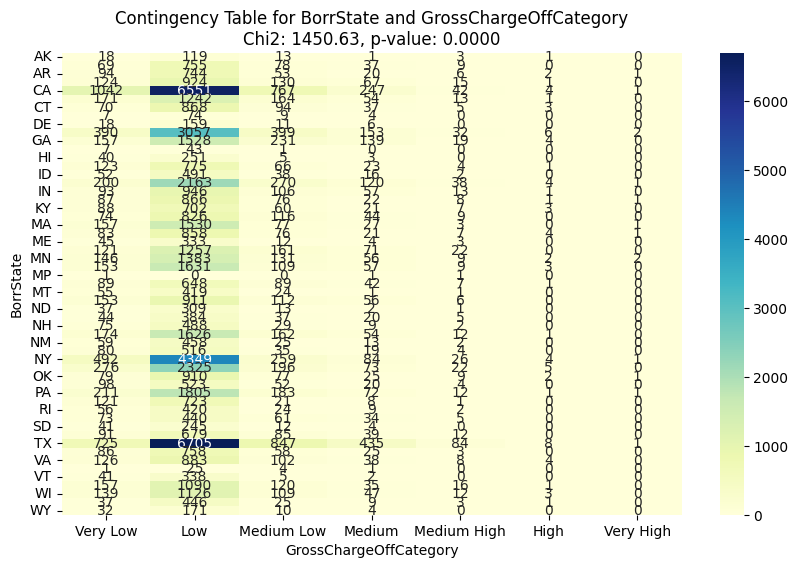

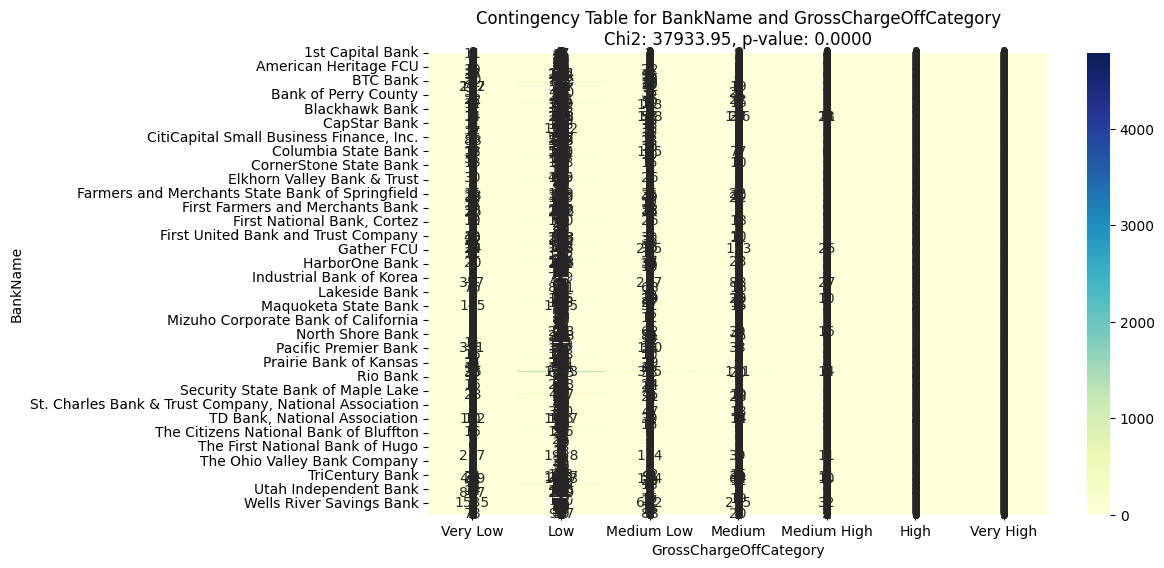

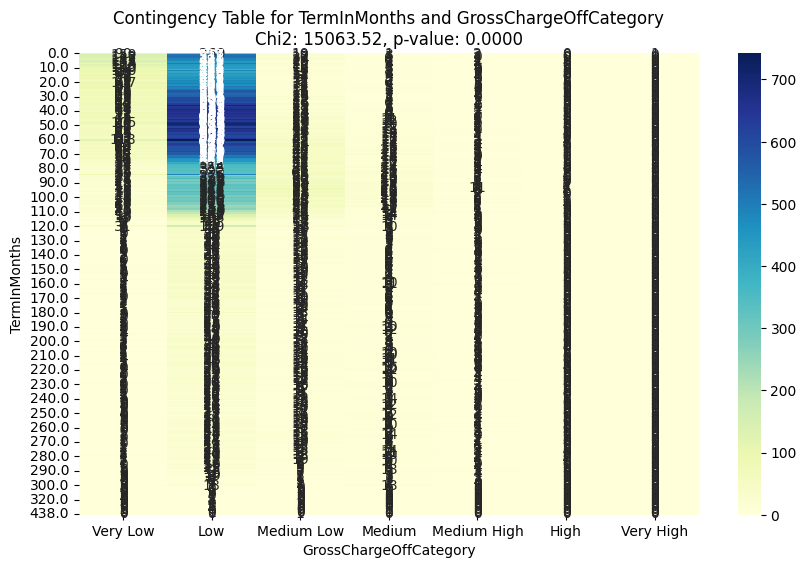

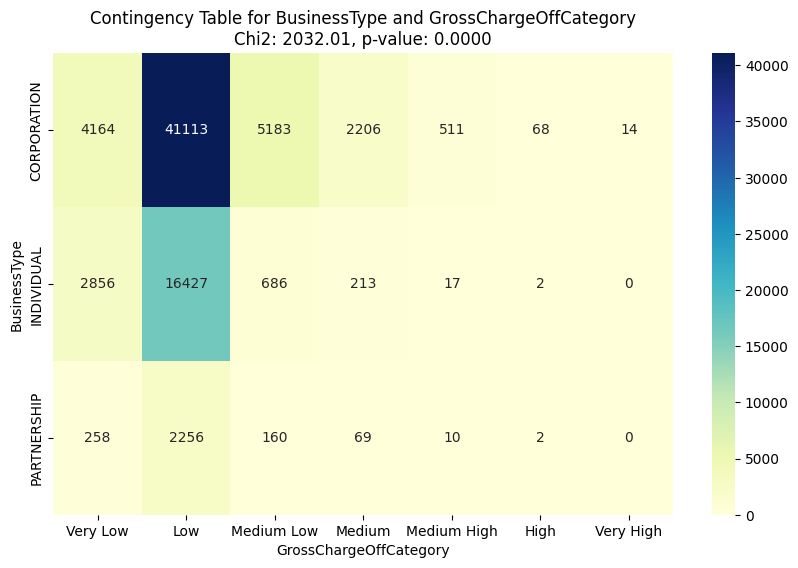


Summary of Chi-Square Tests:
+----+--------------+------------------+-------------+----------------------+--------------------------------------------------------------------------------------------------------------------------------+
|    | Variable     |   Chi2 Statistic |     p-value |   Degrees of Freedom | Contingency Table                                                                                                              |
|----+--------------+------------------+-------------+----------------------+--------------------------------------------------------------------------------------------------------------------------------|
|  0 | BorrState    |          1450.63 | 5.9186e-142 |                  324 | GrossChargeOffCategory  Very Low   Low  Medium Low  Medium  Medium High  High  Very High                                       |
|    |              |                  |             |                      | BorrState                                                       

In [7]:
# Categorize GrossChargeOffAmount
bins = [0, 10000, 250000,500000,1000000,2000000,3000000,4000000]
labels = [ 'Very Low', 'Low', 'Medium Low', 'Medium', 'Medium High', 'High', 'Very High']
combined_df['GrossChargeOffCategory'] = pd.cut(combined_df['GrossChargeOffAmount'], bins=bins, labels=labels)

# Define the function to perform chi-square test
def chi_square_test(combined_df, variable, target):
    # Create a contingency table
    contingency_table = pd.crosstab(combined_df[variable], combined_df[target])
    # Perform the chi-square test
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p, dof, ex, contingency_table

# List of categorical variables to test
categorical_variables = ['BorrState','BankName','TermInMonths', 'BusinessType']

# Perform chi-square test for each categorical variable and GrossChargeOffCategory
results = []
for variable in categorical_variables:
    chi2, p, dof, ex, contingency_table = chi_square_test(combined_df, variable, 'GrossChargeOffCategory')
    results.append((variable, chi2, p, dof, contingency_table))
    print(f'Chi-Square Test for {variable} and GrossChargeOffCategory:')
    print(f'Chi2: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of Freedom: {dof}')
    print(f'Expected Frequencies: \n{ex}\n')
    print(f'Contingency Table: \n{contingency_table}\n')

# Visualization
for variable, chi2, p, dof, contingency_table in results:
    plt.figure(figsize=(10, 6))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Contingency Table for {variable} and GrossChargeOffCategory\nChi2: {chi2:.2f}, p-value: {p:.4f}')
    plt.xlabel('GrossChargeOffCategory')
    plt.ylabel(variable)
    plt.show()

# Summary Table
summary_data = []
for variable, chi2, p, dof, contingency_table in results:
    summary_data.append([variable, chi2, p, dof, contingency_table.to_string()])

summary_df = pd.DataFrame(summary_data, columns=['Variable', 'Chi2 Statistic', 'p-value', 'Degrees of Freedom', 'Contingency Table'])

print("\nSummary of Chi-Square Tests:")
print(tabulate(summary_df, headers='keys', tablefmt='psql'))



# Supervised Learning

In [8]:
###Feature Engineering
combined_df['LogGrossApproval'] = np.log1p(combined_df['GrossApproval'])

#pick relevant columns for modeling
columns_to_use = ['LogGrossApproval', 'SBAGuaranteedApproval', 'TermInMonths', 'GrossChargeOffAmount', 'LoanStatus']
combined_df = combined_df[columns_to_use]

#split data into features and target variable
X = combined_df.drop('LoanStatus', axis=1)
y = combined_df['LoanStatus']

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


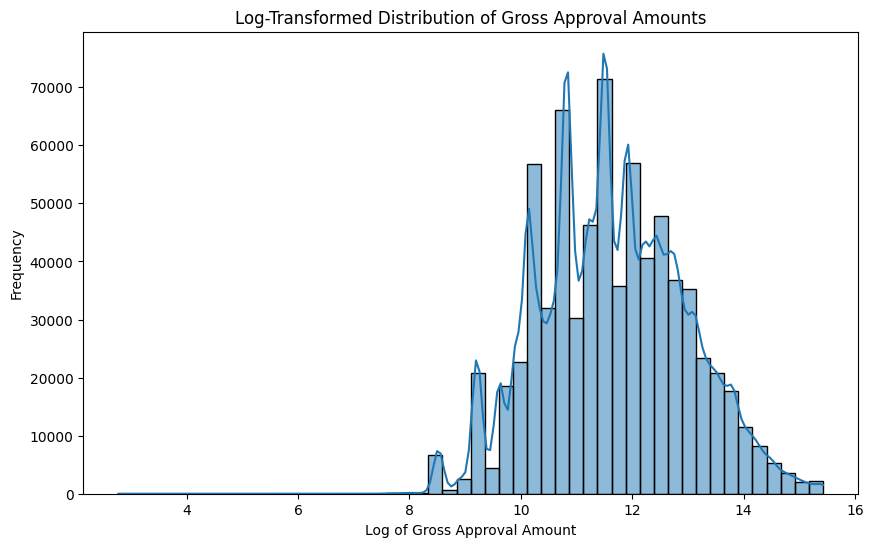

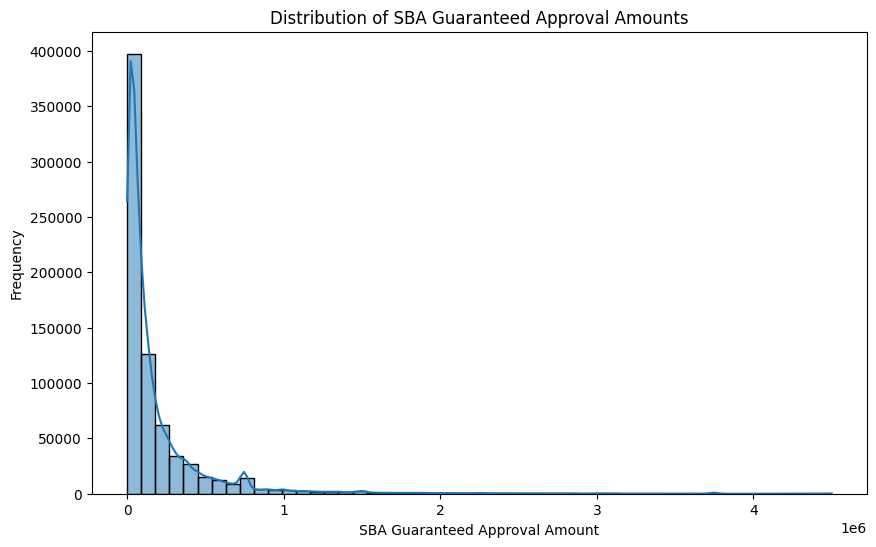

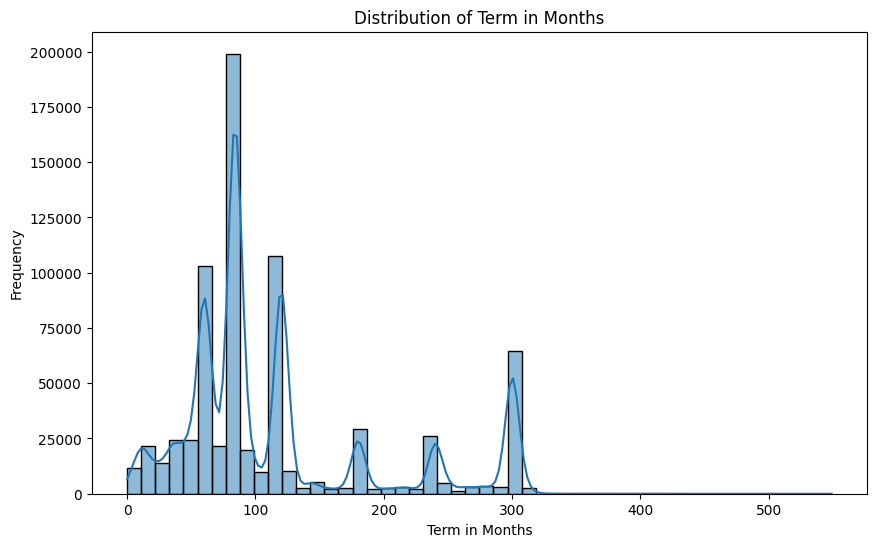

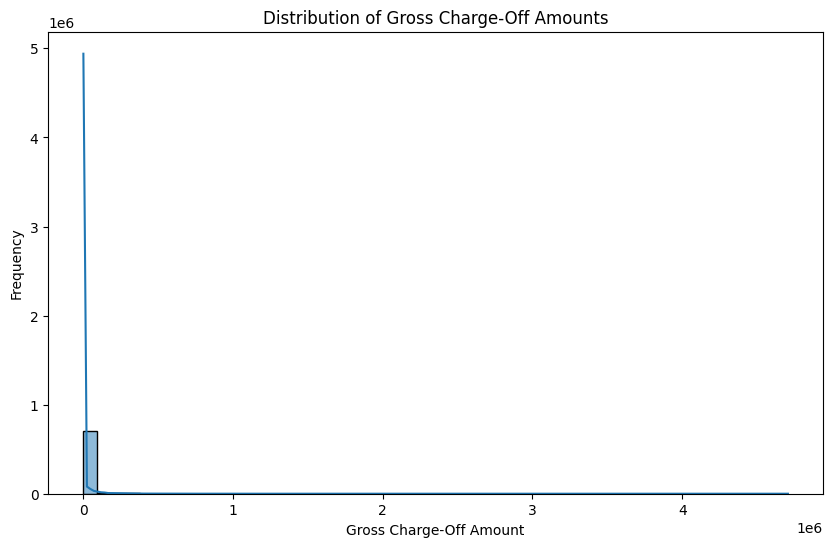

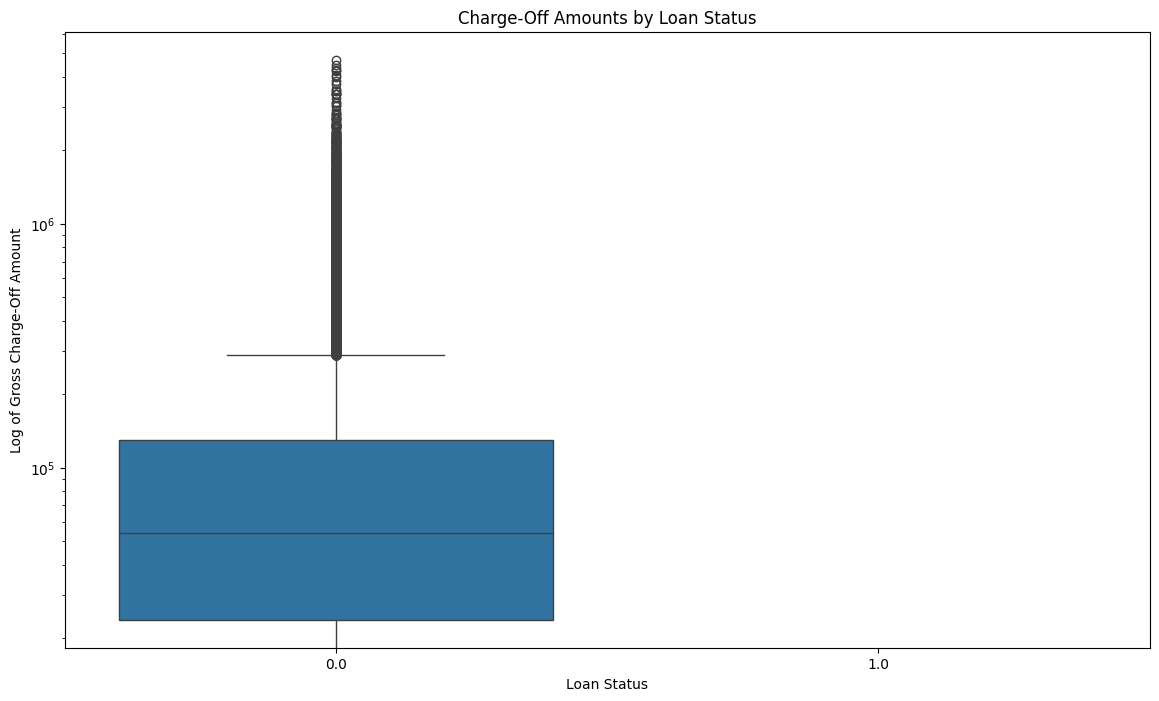

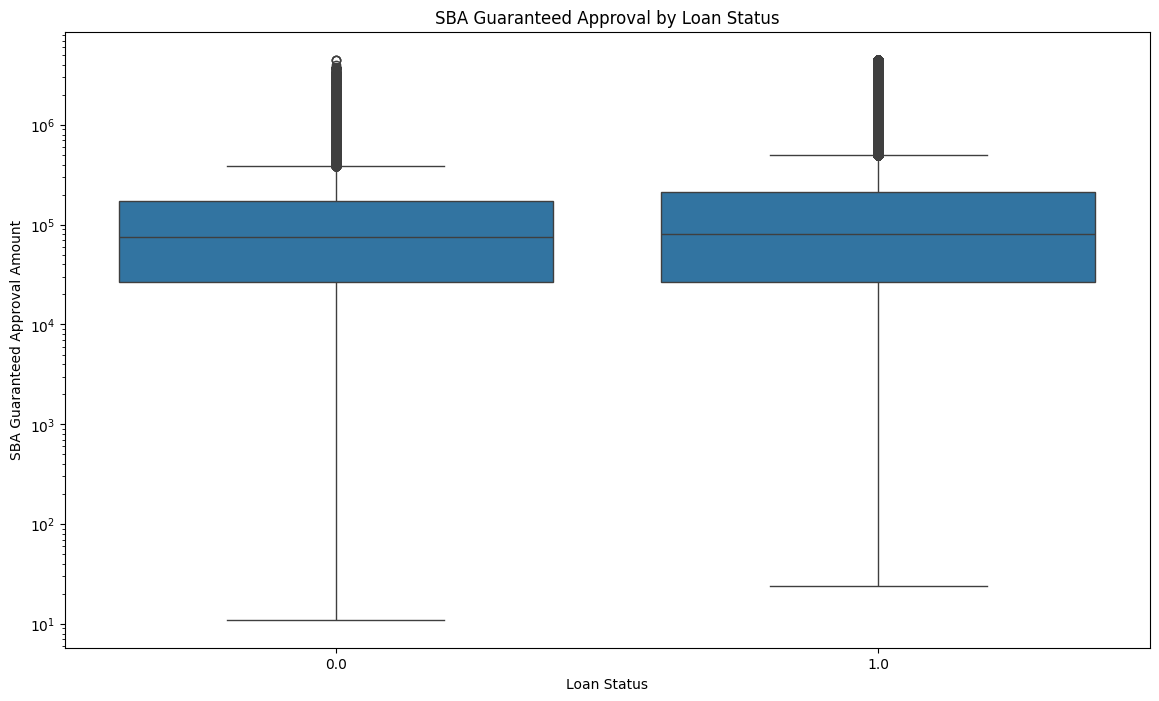

In [9]:
### Exploratory Data Analysis (EDA)

#Distributions of LogGrossApproval
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['LogGrossApproval'], bins=50, kde=True)
plt.title('Log-Transformed Distribution of Gross Approval Amounts')
plt.xlabel('Log of Gross Approval Amount')
plt.ylabel('Frequency')
plt.show()

# Distributions of SBAGuaranteedApproval
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['SBAGuaranteedApproval'], bins=50, kde=True)
plt.title('Distribution of SBA Guaranteed Approval Amounts')
plt.xlabel('SBA Guaranteed Approval Amount')
plt.ylabel('Frequency')
plt.show()

#Distributions of TermInMonths
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['TermInMonths'], bins=50, kde=True)
plt.title('Distribution of Term in Months')
plt.xlabel('Term in Months')
plt.ylabel('Frequency')
plt.show()

#Distributions of GrossChargeOffAmount
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['GrossChargeOffAmount'], bins=50, kde=True)
plt.title('Distribution of Gross Charge-Off Amounts')
plt.xlabel('Gross Charge-Off Amount')
plt.ylabel('Frequency')
plt.show()

#GrossChargeOffAmount by LoanStatus
plt.figure(figsize=(14, 8))
sns.boxplot(x='LoanStatus', y='GrossChargeOffAmount', data=combined_df)
plt.title('Charge-Off Amounts by Loan Status')
plt.yscale('log')
plt.xlabel('Loan Status')
plt.ylabel('Log of Gross Charge-Off Amount')
plt.show()

#SBAGuaranteedApproval by LoanStatus
plt.figure(figsize=(14, 8))
sns.boxplot(x='LoanStatus', y='SBAGuaranteedApproval', data=combined_df)
plt.title('SBA Guaranteed Approval by Loan Status')
plt.yscale('log')
plt.xlabel('Loan Status')
plt.ylabel('SBA Guaranteed Approval Amount')
plt.show()

#Pairplot to see interactions
#sns.pairplot(combined_df, hue='LoanStatus', diag_kind='kde')
#plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree Classifier Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15337
         1.0       1.00      1.00      1.00    130166

    accuracy                           1.00    145503
   macro avg       1.00      1.00      1.00    145503
weighted avg       1.00      1.00      1.00    145503



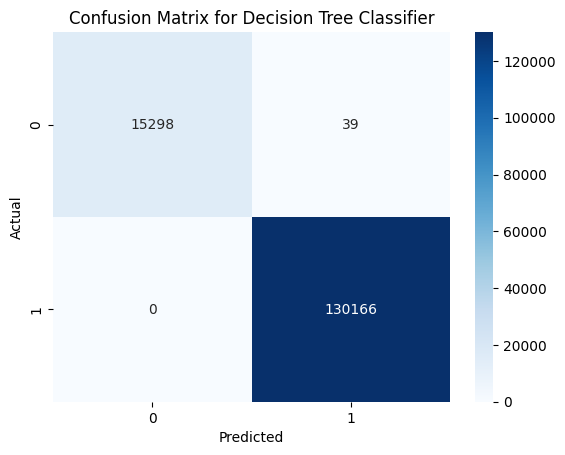

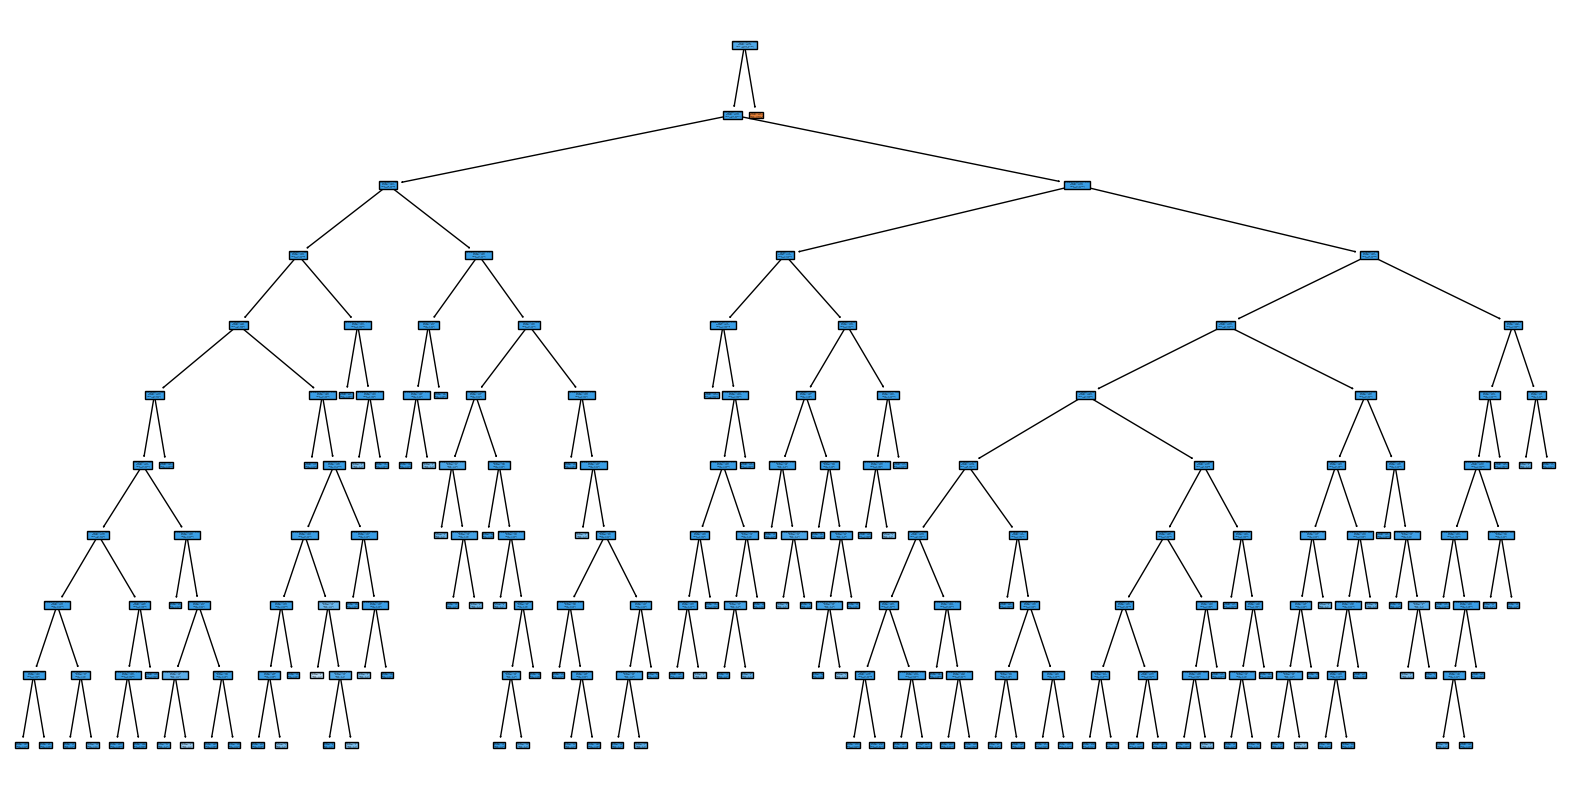

In [10]:
### Decision Tree Classifier with Hyperparameter Tuning

#hyperparameter tuning using GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_classifier = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

#best parameters
print(f"Best parameters: {grid_search.best_params_}")

#Decision Tree with best parameters
best_dt_classifier = grid_search.best_estimator_
best_dt_classifier.fit(X_train, y_train)
y_pred_dt = best_dt_classifier.predict(X_test)

#model evaluation
print("Decision Tree Classifier Report:")
print(classification_report(y_test, y_pred_dt))

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt_classifier, filled=True, feature_names=X.columns, class_names=['CHGOFF', 'PIF'])
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Random Forest Classifier Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15337
         1.0       1.00      1.00      1.00    130166

    accuracy                           1.00    145503
   macro avg       1.00      1.00      1.00    145503
weighted avg       1.00      1.00      1.00    145503



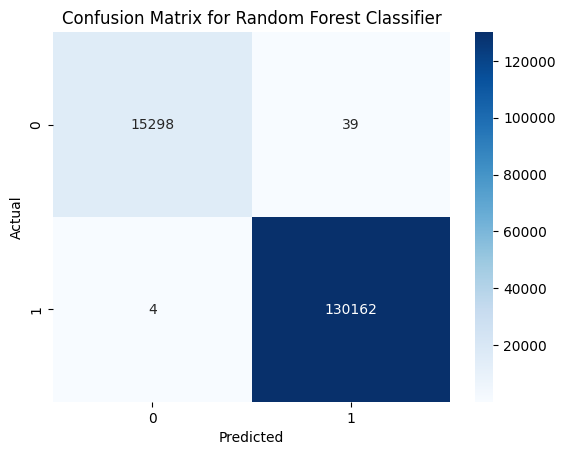

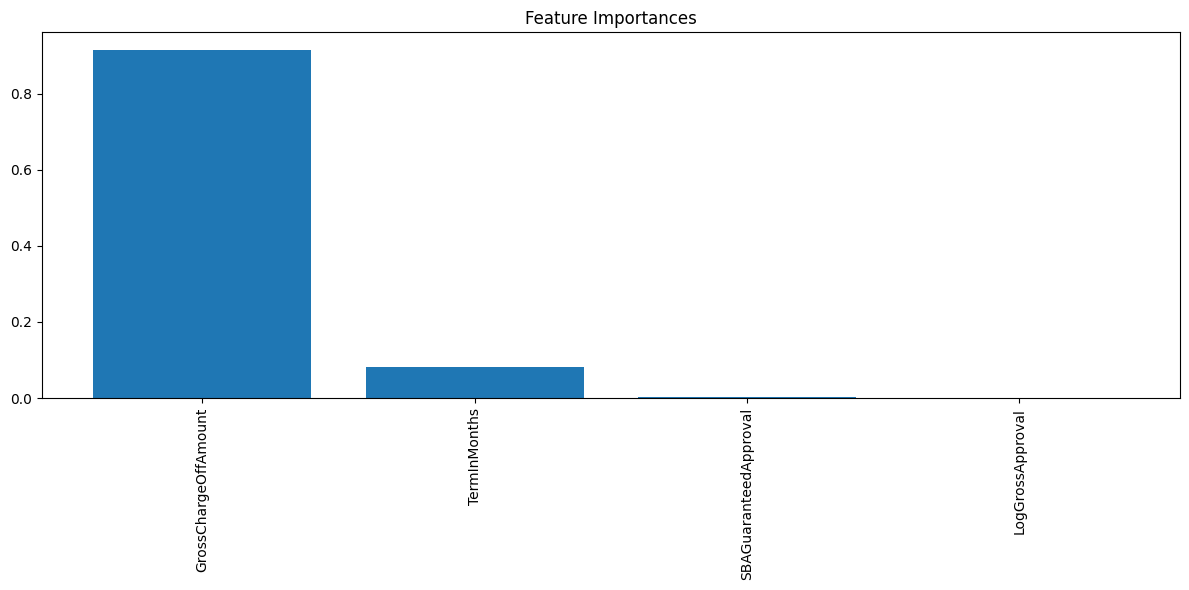

In [11]:
###Random Forest Classifier

#train a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Feature importance
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Logistic Regression Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     15337
         1.0       1.00      1.00      1.00    130166

    accuracy                           1.00    145503
   macro avg       1.00      0.99      0.99    145503
weighted avg       1.00      1.00      1.00    145503



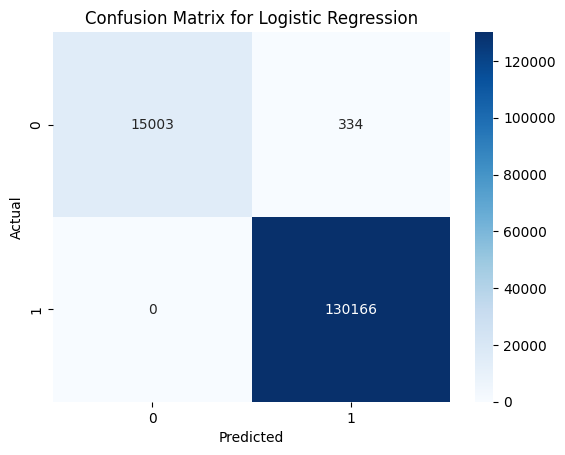

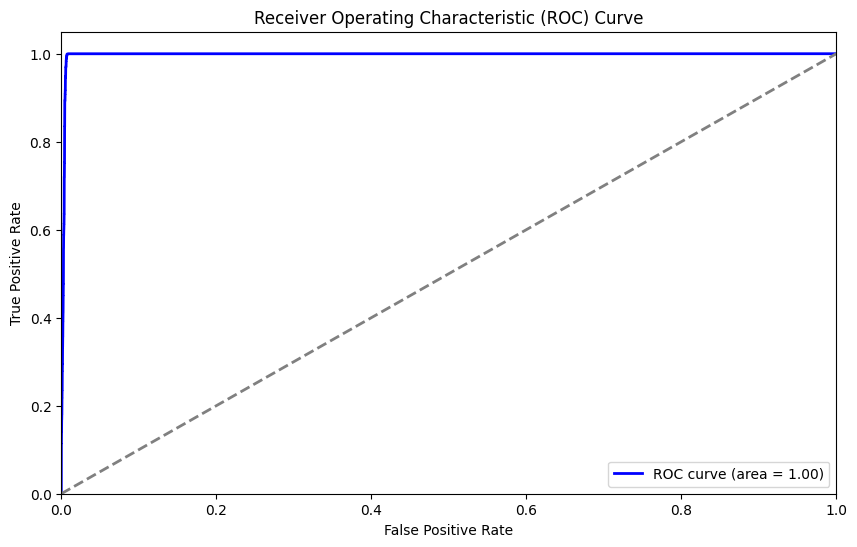

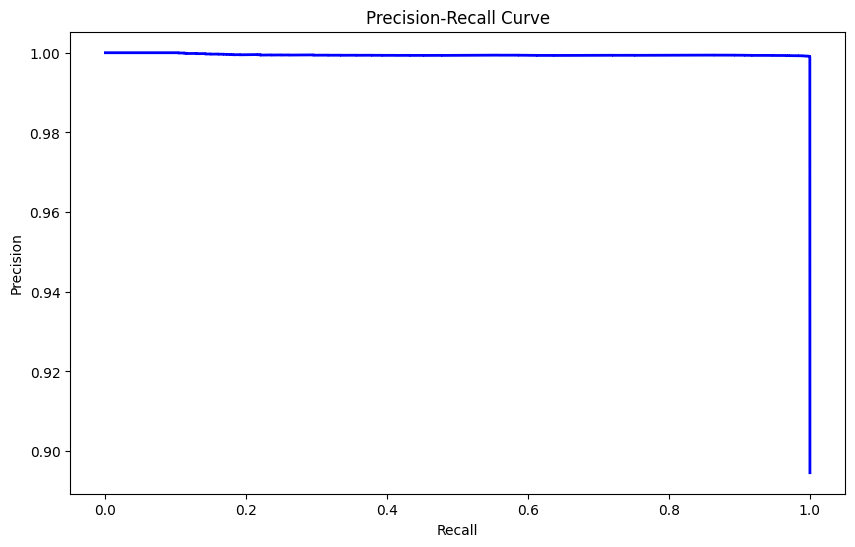

In [12]:
### Logistic Regression Model

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_log_reg))

# Confusion Matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
y_pred_prob_log_reg = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_log_reg)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_log_reg)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


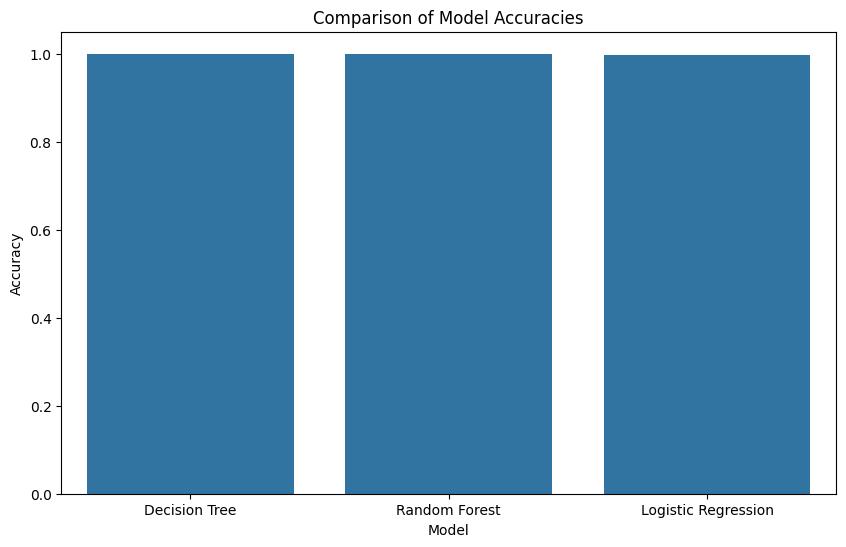

In [13]:
###compare models

models = ['Decision Tree', 'Random Forest', 'Logistic Regression']
accuracies = [
    classification_report(y_test, y_pred_dt, output_dict=True)['accuracy'],
    classification_report(y_test, y_pred_rf, output_dict=True)['accuracy'],
    classification_report(y_test, y_pred_log_reg, output_dict=True)['accuracy']
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()


# Unsupervised Learning

## K-Means

In [14]:
### Clustering (Unsupervised Learning)
# Select relevant columns for clustering
columns_to_use = ['LogGrossApproval', 'SBAGuaranteedApproval', 'TermInMonths', 'GrossChargeOffAmount']
data_for_clustering = combined_df[columns_to_use]

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

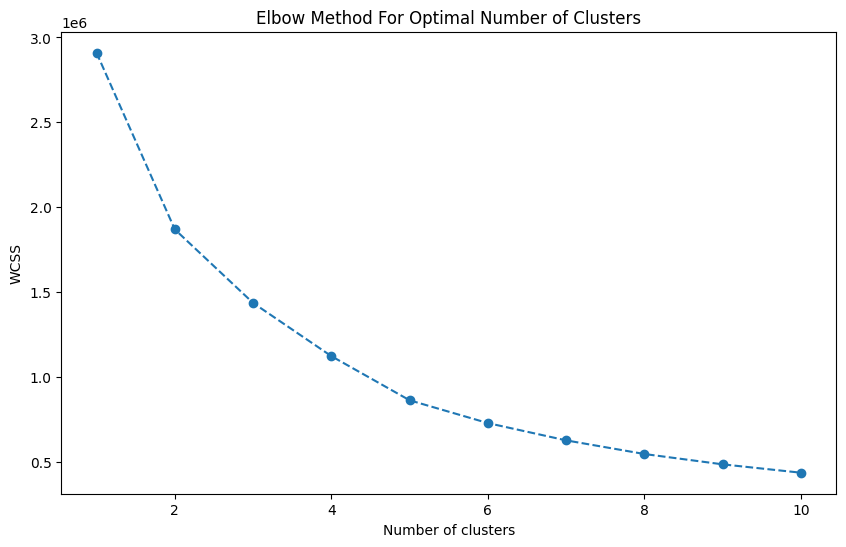

In [15]:
#optimal number of clusters using the Elbow method
wcss = []  # Within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


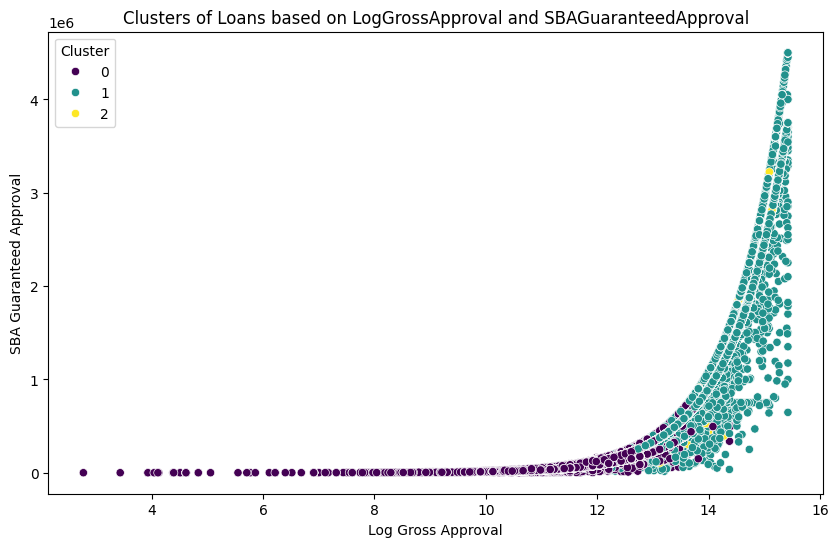

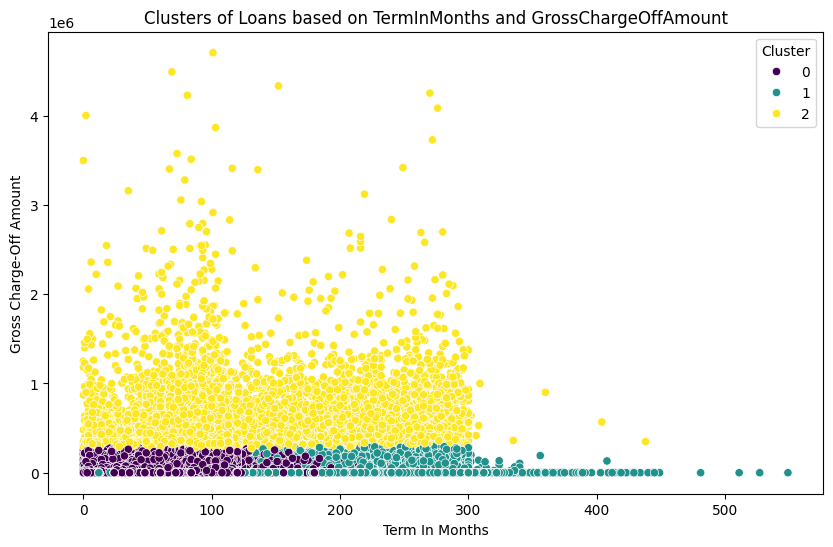

In [16]:
#K-Means with the optimal number of clusters (assuming k=3 from the Elbow method)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Add the cluster labels to the original DataFrame
combined_df['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LogGrossApproval', y='SBAGuaranteedApproval', hue='Cluster', data=combined_df, palette='viridis')
plt.title('Clusters of Loans based on LogGrossApproval and SBAGuaranteedApproval')
plt.xlabel('Log Gross Approval')
plt.ylabel('SBA Guaranteed Approval')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TermInMonths', y='GrossChargeOffAmount', hue='Cluster', data=combined_df, palette='viridis')
plt.title('Clusters of Loans based on TermInMonths and GrossChargeOffAmount')
plt.xlabel('Term In Months')
plt.ylabel('Gross Charge-Off Amount')
plt.show()

## Apriori

In [17]:
#Apriori features
apriori_features = ['BorrState','GrossApproval','SBAGuaranteedApproval','subpgmdesc','TermInMonths','BusinessType','LoanStatus']
apriori_df = combined_df2[apriori_features]
total_nan_count = apriori_df.isna().sum().sum()
print("Total NaN count:", total_nan_count)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total NaN count: 126


In [18]:
#Remove NaN Rows for Assessment
# Remove rows with any NaN values
apriori_cleaned = apriori_df.dropna()
print("\nDataFrame after removing rows with NaN values:")
print(apriori_cleaned)


DataFrame after removing rows with NaN values:
       BorrState  GrossApproval  SBAGuaranteedApproval  \
0             MN        43000.0                38700.0   
1             WI       250000.0               200000.0   
2             IL       330000.0               280500.0   
3             TN       150000.0                84000.0   
4             MD        33500.0                26800.0   
...          ...            ...                    ...   
986329        MI        16500.0                 8250.0   
986330        AZ      1782500.0              1336875.0   
986331        NY        25000.0                12500.0   
986332        VA         5000.0                 2500.0   
986333        TX        10000.0                 5000.0   

                         subpgmdesc  TermInMonths BusinessType LoanStatus  
0                          Guaranty           116   INDIVIDUAL        PIF  
1                          Guaranty            48  CORPORATION        PIF  
2                          

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# Select categorical columns to convert to dummy variables
categorical_columns = ['BorrState', 'subpgmdesc', 'BusinessType', 'LoanStatus']

# Check unique values for categorical columns
for col in categorical_columns:
    print(f"Column {col} has {apriori_cleaned[col].nunique()} unique values.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Column BorrState has 60 unique values.
Column subpgmdesc has 27 unique values.
Column BusinessType has 3 unique values.
Column LoanStatus has 5 unique values.


In [20]:
for col in categorical_columns:
    dummies = pd.get_dummies(apriori_cleaned[col], prefix=col)
    apriori_cleaned = pd.concat([apriori_cleaned, dummies], axis=1)
    apriori_cleaned.drop(col, axis=1, inplace=True)

print(apriori_cleaned.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   GrossApproval  SBAGuaranteedApproval  TermInMonths  BorrState_AK  \
0        43000.0                38700.0           116         False   
1       250000.0               200000.0            48         False   
2       330000.0               280500.0            84         False   
3       150000.0                84000.0            96         False   
4        33500.0                26800.0            84         False   

   BorrState_AL  BorrState_AR  BorrState_AS  BorrState_AZ  BorrState_CA  \
0         False         False         False         False         False   
1         False         False         False         False         False   
2         False         False         False         False         False   
3         False         False         False         False         False   
4         False         False         False         False         False   

   BorrState_CO  ...  subpgmdesc_USCAIP Guaranty (NAFTA)  subpgmdesc_Y2K Loan  \
0         False  ...                     

In [21]:
# Check for non-boolean values in the DataFrame
non_boolean_values = apriori_cleaned.select_dtypes(exclude=["bool"]).columns.tolist()

# Print the non-boolean columns
if len(non_boolean_values) > 0:
    print("Non-boolean columns found:", non_boolean_values)

# Convert non-boolean columns to boolean
for col in non_boolean_values:
    apriori_cleaned[col] = apriori_cleaned[col].astype(bool)

Non-boolean columns found: ['GrossApproval', 'SBAGuaranteedApproval', 'TermInMonths']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Set min_support to the minimum support threshold you want (e.g., 0.1 for 10%)
frequent_itemsets = apriori(apriori_cleaned, min_support=0.1, use_colnames=True)

# Generate association rules from the frequent itemsets
# Set min_threshold to the minimum lift or confidence threshold you want (e.g., 1 for lift)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Print the frequent itemsets
print("Frequent Itemsets:")
print(frequent_itemsets)

# Print the association rules
print("\nAssociation Rules:")
print(rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Frequent Itemsets:
      support                                           itemsets
0    0.999999                                    (GrossApproval)
1    0.999999                            (SBAGuaranteedApproval)
2    0.999533                                     (TermInMonths)
3    0.130730                                     (BorrState_CA)
4    0.314617           (subpgmdesc_FA$TRK (Small Loan Express))
..        ...                                                ...
154  0.271446  (subpgmdesc_Guaranty, LoanStatus_PIF, Business...
155  0.107318  (subpgmdesc_Guaranty, LoanStatus_PIF, SBAGuara...
156  0.170808  (LoanStatus_PIF, subpgmdesc_FA$TRK (Small Loan...
157  0.271446  (subpgmdesc_Guaranty, LoanStatus_PIF, Business...
158  0.107318  (subpgmdesc_Guaranty, LoanStatus_PIF, SBAGuara...

[159 rows x 2 columns]

Association Rules:
                                   antecedents  \
0                      (SBAGuaranteedApproval)   
1                              (GrossApproval)   
2      

In [23]:
# Function to list the best relationships based on a specified metric
def list_best_relationships(rules, metric, top_n=10):
    # Sort the rules by the specified metric
    sorted_rules = rules.sort_values(by=metric, ascending=False)

    # Get the top N rules
    best_rules = sorted_rules.head(top_n)

    return best_rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
#Attempt to Find Relationships that lead to a PIF in LoanStatus

# Set min_threshold to the minimum lift or confidence threshold you want (e.g., 1 for lift)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Filter rules where the consequent is 'LoanStatus_PIF'
rules = rules[rules['consequents'].apply(lambda x: 'LoanStatus_PIF' in x)]

# Print the frequent itemsets
print("Frequent Itemsets:")
print(frequent_itemsets)

# Print the association rules
print("\nAssociation Rules:")
print(rules)

Frequent Itemsets:
      support                                           itemsets
0    0.999999                                    (GrossApproval)
1    0.999999                            (SBAGuaranteedApproval)
2    0.999533                                     (TermInMonths)
3    0.130730                                     (BorrState_CA)
4    0.314617           (subpgmdesc_FA$TRK (Small Loan Express))
..        ...                                                ...
154  0.271446  (subpgmdesc_Guaranty, LoanStatus_PIF, Business...
155  0.107318  (subpgmdesc_Guaranty, LoanStatus_PIF, SBAGuara...
156  0.170808  (LoanStatus_PIF, subpgmdesc_FA$TRK (Small Loan...
157  0.271446  (subpgmdesc_Guaranty, LoanStatus_PIF, Business...
158  0.107318  (subpgmdesc_Guaranty, LoanStatus_PIF, SBAGuara...

[159 rows x 2 columns]

Association Rules:
                                   antecedents  \
11                             (GrossApproval)   
21                     (SBAGuaranteedApproval)   
33     

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# List the top 10 relationships based on lift
best_pif_relationships = list_best_relationships(rules, metric="lift", top_n=10)

# Print the best relationships
print("Top 10 Relationships based on Lift:")
best_pif_relationships


Top 10 Relationships based on Lift:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1178,"(GrossApproval, SBAGuaranteedApproval, TermInM...","(subpgmdesc_Guaranty, LoanStatus_PIF)",0.206492,0.401169,0.107318,0.519717,1.295506,0.024479,1.246829,0.287459
1196,"(SBAGuaranteedApproval, TermInMonths, Business...","(subpgmdesc_Guaranty, LoanStatus_PIF, GrossApp...",0.206492,0.401169,0.107318,0.519717,1.295506,0.024479,1.246829,0.287459
1024,"(GrossApproval, TermInMonths, BusinessType_IND...","(subpgmdesc_Guaranty, LoanStatus_PIF)",0.206492,0.401169,0.107318,0.519717,1.295506,0.024479,1.246829,0.287459
1082,"(SBAGuaranteedApproval, TermInMonths, Business...","(subpgmdesc_Guaranty, LoanStatus_PIF)",0.206492,0.401169,0.107318,0.519717,1.295506,0.024479,1.246829,0.287459
1198,"(GrossApproval, TermInMonths, BusinessType_IND...","(subpgmdesc_Guaranty, LoanStatus_PIF, SBAGuara...",0.206492,0.401169,0.107318,0.519717,1.295506,0.024479,1.246829,0.287459
1212,"(TermInMonths, BusinessType_INDIVIDUAL)","(subpgmdesc_Guaranty, LoanStatus_PIF, SBAGuara...",0.206493,0.401169,0.107318,0.519714,1.295500,0.024479,1.246822,0.287454
1033,"(TermInMonths, BusinessType_INDIVIDUAL)","(subpgmdesc_Guaranty, LoanStatus_PIF, GrossApp...",0.206493,0.401169,0.107318,0.519714,1.295500,0.024479,1.246822,0.287454
1092,"(TermInMonths, BusinessType_INDIVIDUAL)","(subpgmdesc_Guaranty, LoanStatus_PIF, SBAGuara...",0.206493,0.401169,0.107318,0.519714,1.295500,0.024479,1.246822,0.287454
721,"(TermInMonths, BusinessType_INDIVIDUAL)","(subpgmdesc_Guaranty, LoanStatus_PIF)",0.206493,0.401169,0.107318,0.519714,1.295500,0.024479,1.246822,0.287454
966,"(GrossApproval, SBAGuaranteedApproval, Busines...","(subpgmdesc_Guaranty, LoanStatus_PIF)",0.206602,0.401169,0.107330,0.519500,1.294966,0.024447,1.246267,0.287093


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
